# 1 - Introducing data science workflows


** From [https://github.com/ivanovitchm/EEC1509_MachineLearning](https://github.com/ivanovitchm/EEC1509_MachineLearning/tree/master/Lesson%20%2311%20-%20Kaggle%20Fundamentals).**

In this guided project, we're going to put together all that we've learned in this course and create a data science workflow.

By defining a workflow for yourself, you can give yourself a framework with which to make iterating on ideas quicker and easier, allowing yourself to work more efficiently.

In this mission, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

To get started, we'll read in the original **train.csv** and **test.csv** files from Kaggle.



In [0]:
#!mkdir data predictions
#!mv holdout_modified.csv train_modified.csv train.csv test.csv data

In [0]:
import pandas as pd

train = pd.read_csv("./data/train.csv")
holdout = pd.read_csv("./data/test.csv")

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
holdout.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [0]:
survived = train["Survived"]
train = train.drop("Survived",axis=1)

In [6]:
holdout.shape

(418, 11)

In [7]:
train.shape

(891, 11)

In [0]:
## concatenate all data to guarantee that dataset have the same columns
all_data = pd.concat([train,holdout],axis=0)

In [9]:
all_data.shape

(1309, 11)

#2 - Exploring the Data




In the first three missions of this course, we have done a variety of activities, mostly in isolation: **Exploring the data**, **creating features**, **selecting features**, **selecting and tuning different models**.

The Kaggle workflow we are going to build will combine all of these into a process.

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1swb6PxXUJuDvv83ylqh9eUh992lXTu47">

- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then **Submit to Kaggle** to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: **SibSp** and **Parch**.

# 3 - Preprocesing the Data

In [0]:
def process_ticket(df):
    # see https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    Ticket = []
    for i in list(df.Ticket):
        if not i.isdigit():
            #Take prefix
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) 
        else:
            Ticket.append("X")
    df["Ticket"] = Ticket
    return df

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    
    #df = df.drop("Age",axis=1)
    
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    
    df = df.drop("Fare",axis=1)
    
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [0]:
def pre_process(df):
    df = process_ticket(df)
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex","Ticket","Pclass"]:
        df = create_dummies(df,col)
    
    #df = df.drop(["Age_categories","Fare_categories",
                #"Title","Cabin_type","Sex","Ticket"],axis=1)
    
    return df

all_data = pre_process(all_data)

train = all_data.iloc[:891]
train = pd.concat([train,survived],axis=1)
holdout = all_data.iloc[891:]


#4 - Exploring Data



In [12]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 27.8 KB


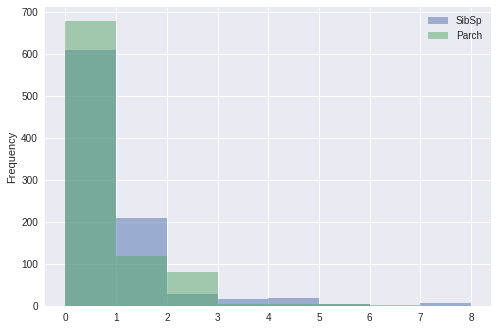

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

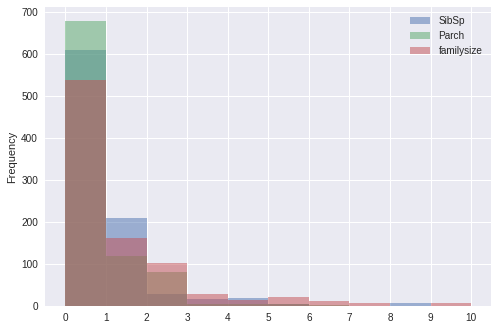

In [14]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

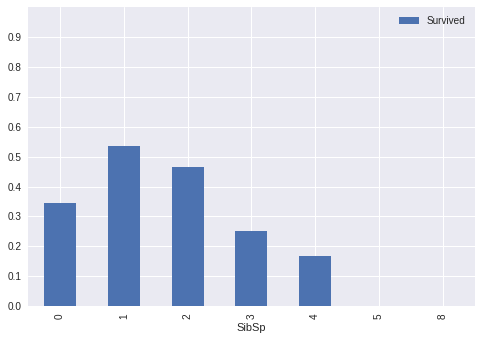

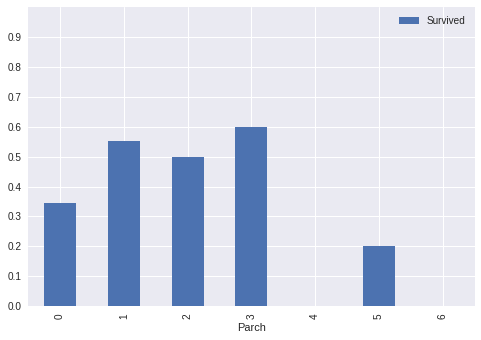

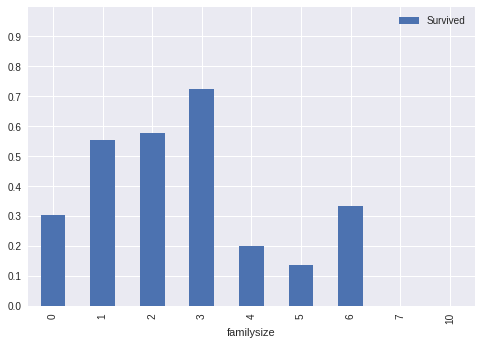

In [15]:
import numpy as np
plt.clf()
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

#5 - Engineering New Features


In [16]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    #df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

#6 - Selecting the Best-Performing Features


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def select_features(df,index):
    
    # index
    # 0 - random forest
    # 1 - logistic regression
    
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf_rf = RandomForestClassifier(random_state=1, n_estimators=100)
    clf_lr = LogisticRegression()
    clfs = [clf_rf,clf_lr]
    
    selector = RFECV(clfs[index],cv=10,n_jobs=-1)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols_rf = select_features(train,0)
cols_lr = select_features(train,1)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Ticket_A4', 'Ticket_A5', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_LINE', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_SWPP', 'Ticket_W

In [18]:
print(len(cols_rf), cols_rf)
print(len(cols_lr), cols_lr)

66 ['Pclass', 'Age', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'Ticket_A4', 'Ticket_A5', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_LINE', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_SWPP', 'Ticket_WC', 'Ticket_WEP', 'Ticke

#7 - Selecting and Tuning Different Algorithms


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import numpy as np

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [200],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [10,20],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1],
                    "min_samples_split": [2]
                }
        },
        {
            "name":"SVC",
            "estimator":SVC(),
            "hyperparameters":
                {
                  "kernel": ['rbf'],  
                  "C": [0.001, 0.01, 0.1, 1, 10],
                  "gamma": [0.001, 0.01, 0.1, 1]
                }
        },
        {
            # reference
            # https://github.com/UltravioletAnalytics/kaggle-titanic/blob/master/sgdclassifier.py
            "name":"SGDC",
            "estimator": SGDClassifier(),
            "hyperparameters":
            {
                "loss": ["log"],
                "alpha": [0.001],
                "penalty": ["elasticnet"],
                "l1_ratio": [0.8],
                "shuffle": [True],
                "learning_rate": ['optimal'],
                "max_iter":[1000]
            }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [20]:
result_a = select_model(train,cols_rf)

LogisticRegression
------------------
Best Score: 0.819304152637486
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8204264870931538
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
----------------------
Best Score: 0.8395061728395061
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

SVC
---
Best Score: 0.8294051627384961
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

SGDC
----
Best Score: 0.797979797979798
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}



In [21]:
result_b = select_model(train,cols_lr)

LogisticRegression
------------------
Best Score: 0.8249158249158249
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.8327721661054994
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8361391694725028
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

SVC
---
Best Score: 0.8361391694725028
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

SGDC
----
Best Score: 0.8249158249158249
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}



#8 - Making a Submission to Kaggle


In [0]:
def save_submission_file(model,cols,filename):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

In [0]:
best_rf_model = result_b[3]["best_model"]
save_submission_file(best_rf_model,cols_lr,"submission_PreprocessingIvanovitch.csv")

#9 - Next Steps




We encourage you to continue working on this Kaggle competition. Here are some suggestions of next steps:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron linear models](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html).
- Experiment with [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of **GridSearchCV** to speed up your **select_features()** function.

Lastly, while the Titanic competition is great for learning about how to approach your first Kaggle competition, we recommend against spending many hours focused on trying to get to the top of the leaderboard. With such a small data set, there is a limit to how good your predictions can be, and your time would be better spent moving onto more complex competitions.

Once you feel like you have a good understanding of the Kaggle workflow, you should look at some other competitions - a great next competition is the [House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). A start point you can find [here](https://www.dataquest.io/blog/kaggle-getting-started/).

# 10 - Loading the modified data

In [0]:
import pandas as pd

train_mod = pd.read_csv("./data/train_modified.csv")
holdout_mod = pd.read_csv("./data/holdout_modified.csv")

In [25]:
print(train_mod.info())
train_mod.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
Survived                      891 non-null int64
PassengerId                   891 non-null int64
Age_categories_Missing        891 non-null int64
Age_categories_Infant         891 non-null int64
Age_categories_Child          891 non-null int64
Age_categories_Teenager       891 non-null int64
Age_categories_Young Adult    891 non-null int64
Age_categories_Adult          891 non-null int64
Age_categories_Senior         891 non-null int64
Pclass_1                      891 non-null int64
Pclass_2                      891 non-null int64
Pclass_3                      891 non-null int64
Sex_female                    891 non-null int64
Sex_male                      891 non-null int64
Embarked_C                    891 non-null int64
Embarked_Q                    891 non-null int64
Embarked_S                    891 non-null int64
SibSp_scaled                  891 non-null float64
Parch_scale

,Survived,PassengerId,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Pclass_1,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,2,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,3,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,4,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
print(holdout_mod.info())
holdout_mod.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 38 columns):
PassengerId                   418 non-null int64
Age_categories_Missing        418 non-null int64
Age_categories_Infant         418 non-null int64
Age_categories_Child          418 non-null int64
Age_categories_Teenager       418 non-null int64
Age_categories_Young Adult    418 non-null int64
Age_categories_Adult          418 non-null int64
Age_categories_Senior         418 non-null int64
Pclass_1                      418 non-null int64
Pclass_2                      418 non-null int64
Pclass_3                      418 non-null int64
Sex_female                    418 non-null int64
Sex_male                      418 non-null int64
Embarked_C                    418 non-null int64
Embarked_Q                    418 non-null int64
Embarked_S                    418 non-null int64
SibSp_scaled                  418 non-null float64
Parch_scaled                  418 non-null float64
Fare_scal

,PassengerId,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Pclass_1,Pclass_2,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,892,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,893,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,894,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,895,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,896,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [0]:
X_mod = train_mod.drop(["Survived","PassengerId"],axis=1)
y_mod = train_mod["Survived"]

# 11 - Using the  AdaBoostClassifier

An AdaBoost [1] classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME [2].

class **sklearn.ensemble.AdaBoostClassifier**(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)[source]


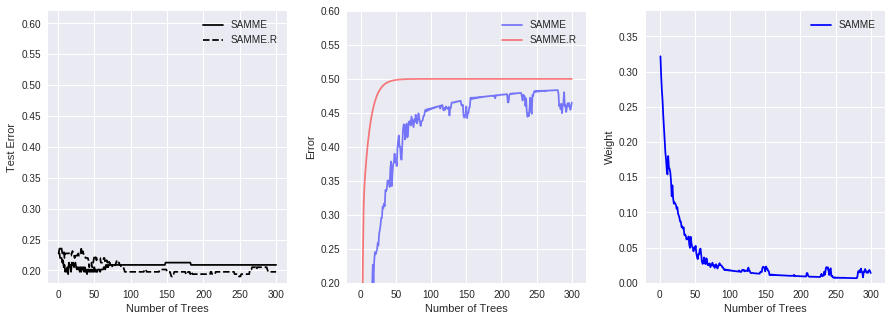

In [28]:
from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=42)


bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=15),
    n_estimators=300,
    learning_rate=0.1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=15),
    n_estimators=300,
    learning_rate=0.1,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

In [29]:
bdt_real

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=300, random_state=None)

In [30]:
print(real_test_errors)
print(discrete_test_errors)

[0.2276119402985075, 0.2350746268656716, 0.2350746268656716, 0.23880597014925375, 0.2350746268656716, 0.2276119402985075, 0.2276119402985075, 0.23134328358208955, 0.2201492537313433, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.2276119402985075, 0.22388059701492535, 0.22388059701492535, 0.2276119402985075, 0.23134328358208955, 0.2276119402985075, 0.22388059701492535, 0.2201492537313433, 0.22388059701492535, 0.22388059701492535, 0.2276119402985075, 0.22388059701492535, 0.2276119402985075, 0.22388059701492535, 0.2276119402985075, 0.2276119402985075, 0.2350746268656716, 0.2276119402985075, 0.23134328358208955, 0.2276119402985075, 0.22388059701492535, 0.22388059701492535, 0.2201492537313433, 0.2201492537313433, 0.2201492537313433, 0.2201492537313433, 0.21641791044776115, 0.2052238805970149, 0.2126865671641791, 0.2126865671641791, 0.2126865671641791, 0.2052238805970149, 0.20895522388059706, 0.21641791044776115, 0.2

In [31]:
print(bdt_real.score(X_test, y_test))
print(bdt_discrete.score(X_test, y_test))

0.8022388059701493
0.7910447761194029


In [32]:
# make the prediction using the resulting model
holdout_pred = holdout_mod.drop(["PassengerId"],axis=1)

predictions = bdt_real.predict(holdout_pred)

print("class = ", predictions)

holdout_ids = holdout_mod["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_AdaBoostClassifier_real_0.csv",index=False)


class =  [0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0
 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [33]:
# make the prediction using the resulting model
holdout_pred = holdout_mod.drop(["PassengerId"],axis=1)

predictions = bdt_discrete.predict(holdout_pred)

print("class = ", predictions)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_AdaBoostClassifier_discrete_0.csv",index=False)

class =  [0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0
 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


## 11.1 Plot feature importance of AdaBoostClassifier Discrete

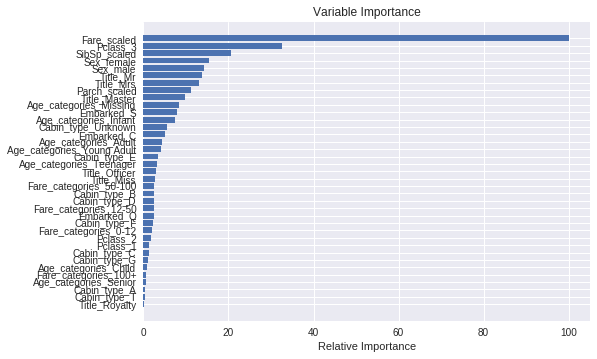

In [34]:

import numpy as np
import matplotlib.pyplot as plt


# #############################################################################
# Plot feature importance
feature_importance = bdt_discrete.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_mod.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

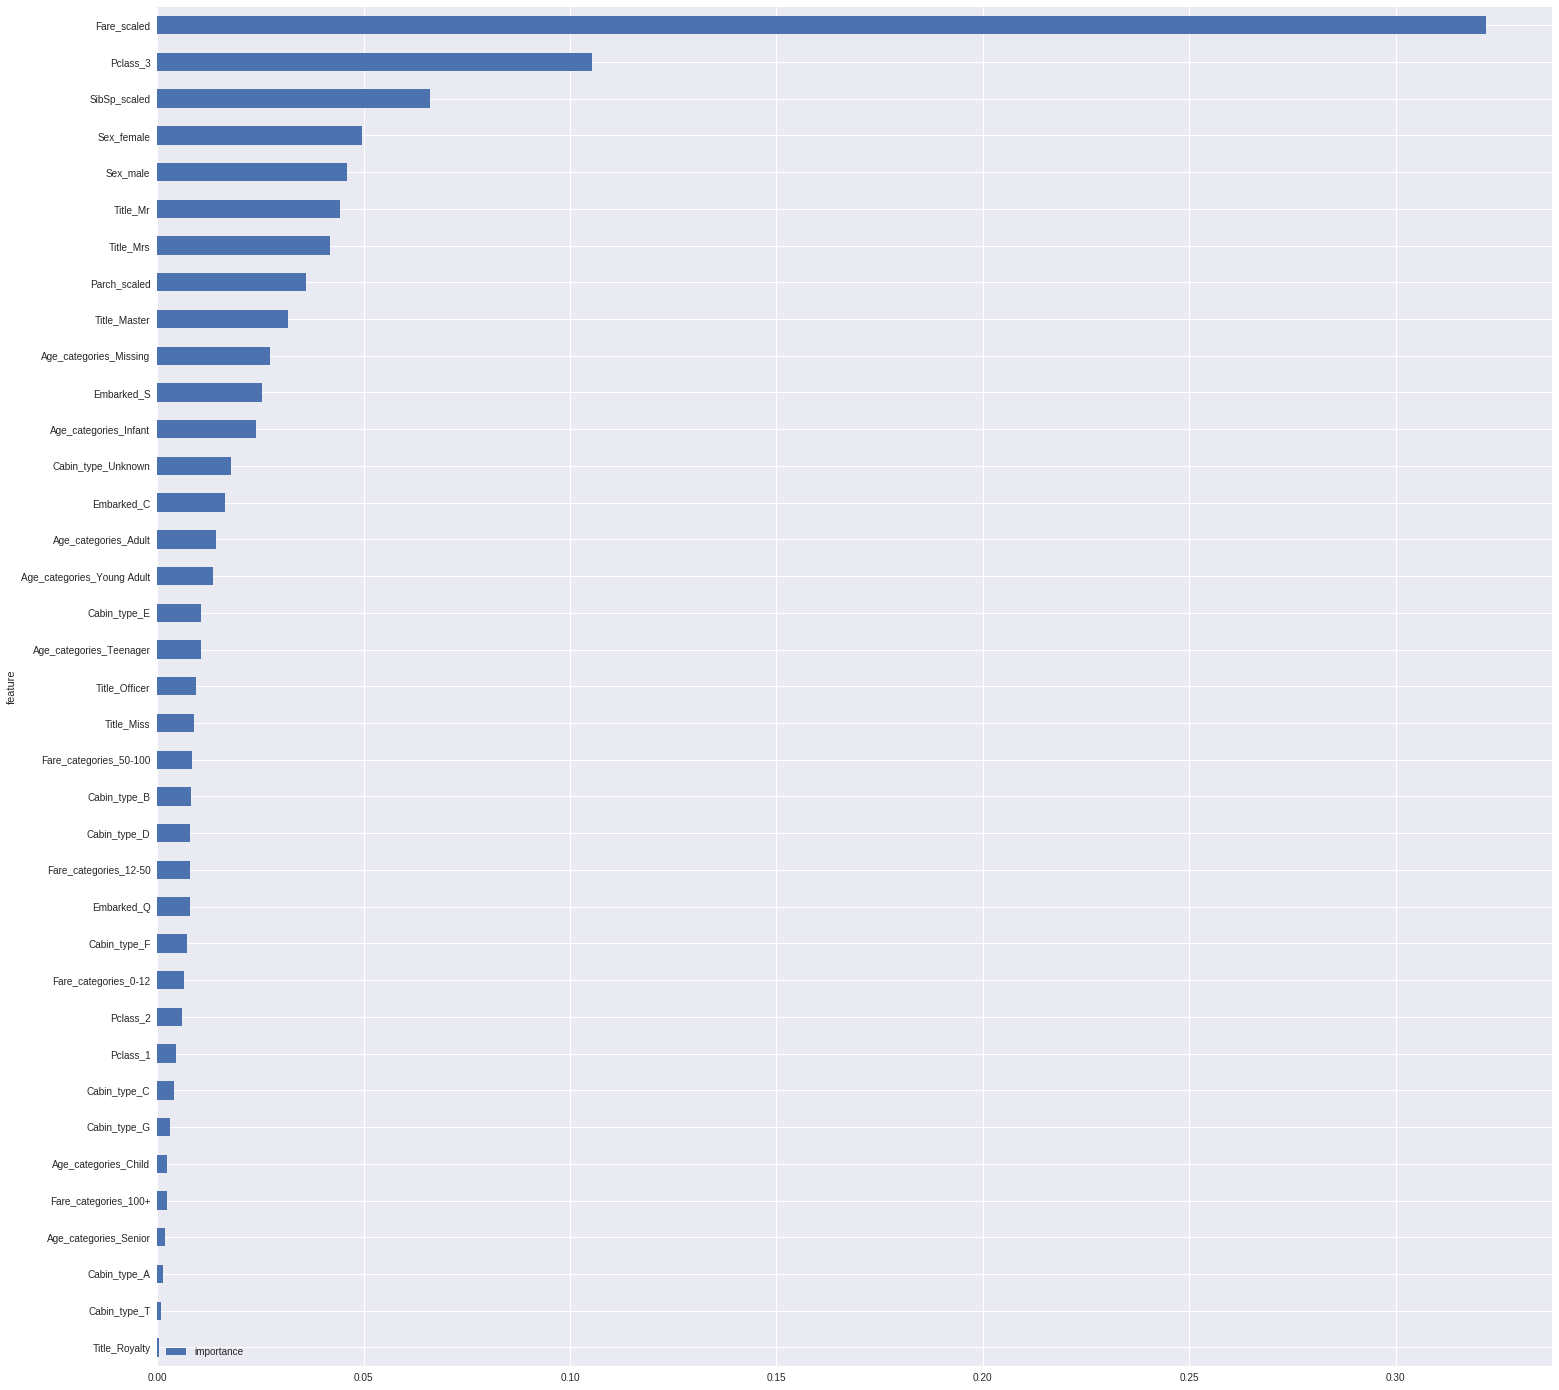

In [35]:
features = pd.DataFrame()
features['feature'] = X_mod.columns
features['importance'] = bdt_discrete.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))


/usr/local/lib/python3.6/dist-packages/sklearn/tree/tree.py:508: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


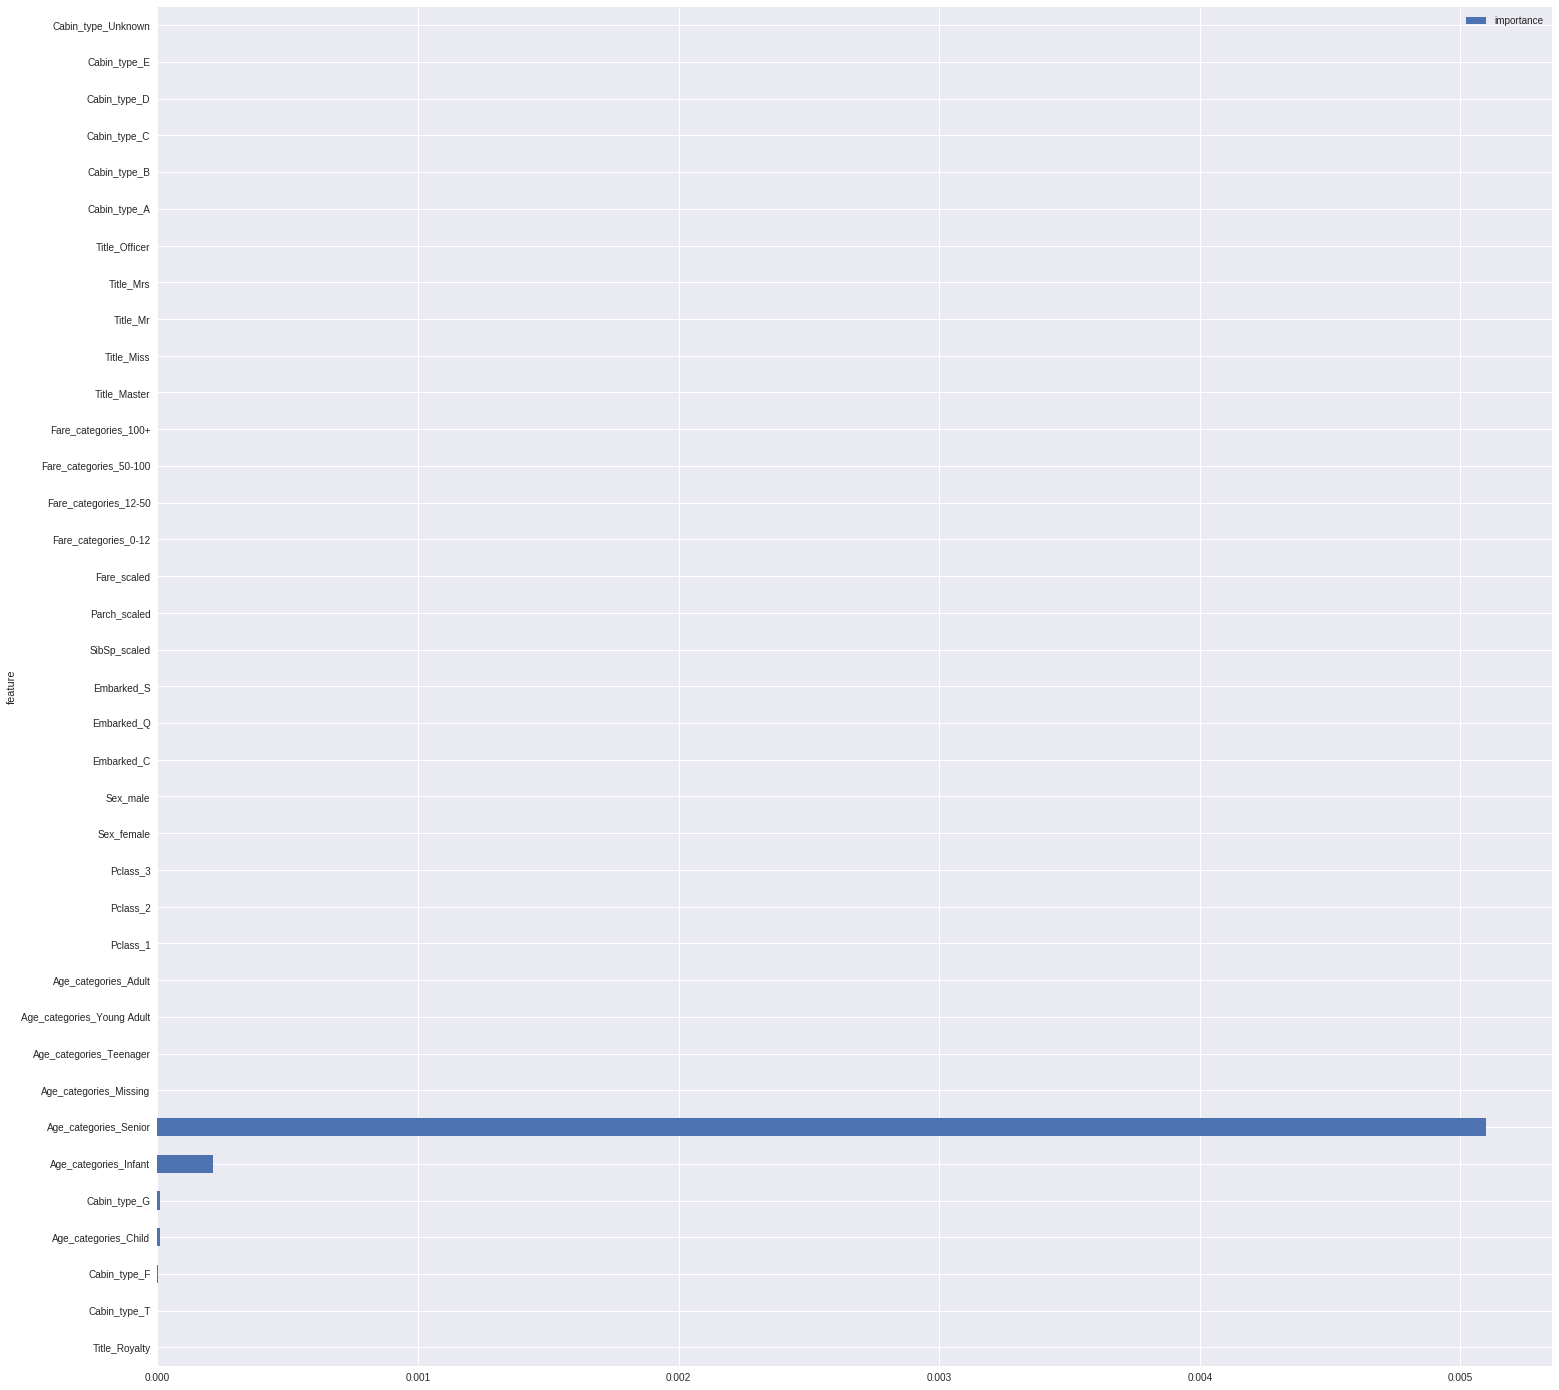

In [36]:
features = pd.DataFrame()
features['feature'] = X_mod.columns
features['importance'] = bdt_real.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))


## 11.2 Tunning the AdaBoostClassifier with RandomizedSearchCV 




In [37]:

import numpy as np

from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits

import numpy as np
from catboost import CatBoostClassifier

# specify the training parameters 
#clf = AdaBoostClassifier(learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')
clf = AdaBoostClassifier()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#AdaBoostClassifier(algorithm='SAMME.R',
#          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
#            max_features=None, max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
#            splitter='best'),
#          learning_rate=0.1, n_estimators=300, random_state=None)            

# specify parameters and distributions to sample from
param_dist = {#"iterations": sp_randint(15,50),
              #"max_depth" : sp_randint(5,16),
              "base_estimator" : [RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=15) , DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best') ],
             "learning_rate" : uniform(0.1, 1),
              "n_estimators" : sp_randint(10, 100),
               "algorithm" : ['SAMME', 'SAMME.R']}

# run randomized search 

#ValueError: Invalid parameter iterations for estimator AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
#          learning_rate=1.0, n_estimators=50, random_state=None). Check the list of available parameters with `estimator.get_params().keys()`.
  
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)



RandomizedSearchCV took 72.18 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.820 (std: 0.025)
Parameters: {'algorithm': 'SAMME', 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'learning_rate': 0.30236449087667916, 'n_estimators': 36}

Model with rank: 2
Mean validation score: 0.816 (std: 0.024)
Parameters: {'algorithm': 'SAMME', 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         

In [38]:
random_search.best_params_

{'algorithm': 'SAMME',
 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'learning_rate': 0.30236449087667916,
 'n_estimators': 36}

In [39]:
random_search

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'base_estimator': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,....stats._distn_infrastructure.rv_frozen object at 0x7f2f92921c88>, 'algorithm': ['SAMME', 'SAMME.R']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [40]:
print(random_search.score(X_mod, y_mod))
print(random_search.score(X_train, y_train))
print(random_search.score(X_test, y_test))

0.9405162738496072
0.9550561797752809
0.8111111111111111


In [0]:
holdout_mod = pd.read_csv("./data/holdout_modified.csv")

## 11.2 Tunning the AdaBoostClassifier with RandomizedSearchCV 
predictions = random_search.predict(holdout_mod.drop(["PassengerId"], axis = 1))

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_AdaBoostClassifierRandomizedSearchCV0.csv",index=False)

**Score of 0.73684**

# 12 - Using the CatBoost: Score of 0.80382


Here we implements an Soluting using the CatBoost algorithm implementation.

CatBoost is a machine learning algorithm that uses gradient boosting on decision trees:

https://tech.yandex.com/catboost/doc/dg/concepts/python-quickstart-docpage/

## 12.1 - Installing the CatBoost

In [42]:
!pip install catboost


## 12.2 - Loading the modified data and executing the CatBoost

In [0]:
import pandas as pd

train_mod = pd.read_csv("./data/train_modified.csv")
holdout_mod = pd.read_csv("./data/holdout_modified.csv")
X_mod = train_mod.drop(["Survived","PassengerId"],axis=1)
y_mod = train_mod["Survived"]

In [44]:
import numpy as np
from catboost import CatBoostClassifier

# specify the training parameters 
model = CatBoostClassifier(iterations=46, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=42)

#train the model
#model.fit(X_train, y_train)

model.fit(X_mod, y_mod)

score_train = model.score(X_train, y_train)
print("Accuracy of Train Data", score_train)

score_test = model.score(X_test, y_test)
print("Accuracy of Test Data", score_test)

# make the prediction using the resulting model
predictions = model.predict(holdout_mod).astype(int)

print("class = ", predictions)

#preds_proba = model.predict_proba(test_data)
#print("proba = ", preds_proba)




0:	learn: 0.6265622	total: 147ms	remaining: 6.61s
1:	learn: 0.5910866	total: 164ms	remaining: 3.61s
2:	learn: 0.5649577	total: 181ms	remaining: 2.6s
3:	learn: 0.5313262	total: 199ms	remaining: 2.09s
4:	learn: 0.4995271	total: 218ms	remaining: 1.78s
5:	learn: 0.4776072	total: 240ms	remaining: 1.6s
6:	learn: 0.4566935	total: 290ms	remaining: 1.61s
7:	learn: 0.4460178	total: 308ms	remaining: 1.46s
8:	learn: 0.4351366	total: 326ms	remaining: 1.34s
9:	learn: 0.4232154	total: 402ms	remaining: 1.45s
10:	learn: 0.4179599	total: 416ms	remaining: 1.32s
11:	learn: 0.4128288	total: 431ms	remaining: 1.22s
12:	learn: 0.4043546	total: 503ms	remaining: 1.28s
13:	learn: 0.3969661	total: 551ms	remaining: 1.26s
14:	learn: 0.3918912	total: 580ms	remaining: 1.2s
15:	learn: 0.3861208	total: 657ms	remaining: 1.23s
16:	learn: 0.3845066	total: 671ms	remaining: 1.15s
17:	learn: 0.3799393	total: 691ms	remaining: 1.07s
18:	learn: 0.3792572	total: 704ms	remaining: 1s
19:	learn: 0.3762985	total: 735ms	remaining: 95

In [0]:

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_CatBoostClassifier_1.csv",index=False)


**Score of 0.80382**



![Rank on the Kaggle](https://drive.google.com/uc?export=view&id=1N8GM-_16JgWArc_-v9vc5nmghRKaplLw)




###  12.2.1 - Best result with CatBoostClassifier

`CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')`



## 12.3 - Using a Pool of CatBoost with Cross-validation

In [0]:
from catboost import Pool, cv

pool = Pool(X_mod, y_mod)

params = {'iterations': 100, 
          'depth': 3,        
          'loss_function': 'Logloss', 
          'verbose': False, 
          'roc_file': 'roc-file'}

scores = cv(pool,params)

In [47]:
scores


,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0.634429,0.001967,0.631455,0.007169
1,0.588940,0.004227,0.583346,0.012132
2,0.556678,0.006480,0.549612,0.016065
3,0.537791,0.008543,0.529330,0.019017
4,0.524288,0.011245,0.514679,0.019511
5,0.504129,0.014142,0.494408,0.021196
6,0.490563,0.015021,0.481200,0.019821
7,0.480098,0.016752,0.470309,0.020463
8,0.471156,0.021702,0.459900,0.018421
9,0.466393,0.023367,0.453930,0.018102


## 12.4 Tunning the CatBoost with RandomizedSearchCV: Bad Score of 0.74162


In [48]:
#from scipy.stats import randint as sp_randint

np.linspace(0,1.5,16)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5])

In [49]:

import numpy as np

from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
#from sklearn.ensemble import RandomForestClassifier

import numpy as np
from catboost import CatBoostClassifier

# specify the training parameters 
clf = CatBoostClassifier(loss_function='Logloss', logging_level='Verbose')


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"iterations": sp_randint(15,50),
              "depth" : sp_randint(5,16),
              "learning_rate" : np.linspace(0,1,16)}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X_mod, y_mod)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid =  {"iterations": sp_randint(15,50),
              "depth" : sp_randint(5,16),
              "learning_rate" : uniform(0,1)}

clf_grid = CatBoostClassifier(learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')

# run grid search
#grid_search = GridSearchCV(clf_grid, param_grid=param_grid, cv=5)
#start = time()
#grid_search.fit(X_mod, y_mod)

#print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#      % (time() - start, len(grid_search.cv_results_['params'])))
#report(grid_search.cv_results_)

0:	learn: 0.4261553	total: 53.8ms	remaining: 2.37s
1:	learn: 0.4092715	total: 83.9ms	remaining: 1.8s
2:	learn: 0.3719364	total: 120ms	remaining: 1.68s
3:	learn: 0.3562007	total: 147ms	remaining: 1.51s
4:	learn: 0.3473280	total: 182ms	remaining: 1.46s
5:	learn: 0.3401415	total: 209ms	remaining: 1.36s
6:	learn: 0.3388880	total: 232ms	remaining: 1.26s
7:	learn: 0.3128254	total: 477ms	remaining: 2.2s
8:	learn: 0.3028359	total: 506ms	remaining: 2.02s
9:	learn: 0.2991698	total: 537ms	remaining: 1.88s
10:	learn: 0.2973588	total: 563ms	remaining: 1.74s
11:	learn: 0.2885502	total: 760ms	remaining: 2.09s
12:	learn: 0.2754490	total: 954ms	remaining: 2.35s
13:	learn: 0.2720943	total: 1s	remaining: 2.22s
14:	learn: 0.2716304	total: 1.04s	remaining: 2.07s
15:	learn: 0.2714151	total: 1.06s	remaining: 1.93s
16:	learn: 0.2713426	total: 1.09s	remaining: 1.79s
17:	learn: 0.2703136	total: 1.12s	remaining: 1.68s
18:	learn: 0.2635573	total: 1.33s	remaining: 1.82s
19:	learn: 0.2583338	total: 1.55s	remaining:


**The learning rate must be less than 1.**


In [50]:
print("Random_search best_score:", random_search.best_score_)
#print("Grid_search best_score:", grid_search.best_score_,"\n")

print("Random_search best_score:", random_search.best_params_)
#print("Grid_search best_score:", grid_search.best_params_,"\n")

Random_search best_score: 0.8282828282828283
Random_search best_score: {'depth': 12, 'iterations': 21, 'learning_rate': 0.6666666666666666}


In [0]:
predictions = random_search.predict(holdout_mod).astype(int)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_CatBoostClassifier_Random_Search.csv",index=False)


![alt text](https://drive.google.com/uc?export=view&id=1n7LSwZz7UIHOiXAxsVfitxCX6VNJSyMS)


**BAD! Overfit with: **

**Random_search best_score: {'depth': 10, 'iterations': 46, 'learning_rate': 0.5} **

# 13 - Appling the Voting strategy for Ensemble

In [0]:
import pandas as pd

train_mod = pd.read_csv("./data/train_modified.csv")
holdout_mod = pd.read_csv("./data/holdout_modified.csv")
X_mod = train_mod.drop(["Survived","PassengerId"],axis=1)
y_mod = train_mod["Survived"]

In [53]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats

auc = make_scorer(roc_auc_score)
rand_list = {"C": stats.uniform(2, 10),
                        "gamma": stats.uniform(0.1, 1)}


# X_train0, X_test0, y_train0, y_test0 = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)
#X = train[0::, 1::]
#y = train[0::, 0]
X = X_mod
y = y_mod
clf = SVC()


rand_search = RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
rand_search.fit(X,y)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=4,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f926f9908>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f926f9320>},
          pre_dispatch='2*n_jobs', random_state=2017, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=0)

In [54]:
rand_search.best_estimator_

SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5565289675398223,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6566896	total: 89.9ms	remaining: 1.71s
1:	learn: 0.6025596	total: 134ms	remaining: 1.2s
2:	learn: 0.5513138	total: 288ms	remaining: 1.63s
3:	learn: 0.5126495	total: 378ms	remaining: 1.51s
4:	learn: 0.4858538	total: 409ms	remaining: 1.23s
5:	learn: 0.4630220	total: 498ms	remaining: 1.16s
6:	learn: 0.4412954	total: 550ms	remaining: 1.02s
7:	learn: 0.4304708	total: 604ms	remaining: 905ms
8:	learn: 0.4232013	total: 630ms	remaining: 770ms
9:	learn: 0.4087937	total: 763ms	remaining: 763ms
10:	learn: 0.4014701	total: 828ms	remaining: 678ms
11:	learn: 0.3947662	total: 891ms	remaining: 594ms
12:	learn: 0.3897094	total: 1.02s	remaining: 548ms
13:	learn: 0.3826334	total: 1.14s	remaining: 490ms
14:	learn: 0.3775345	total: 1.23s	remaining: 411ms
15:	learn: 0.3709895	total: 1.38s	remaining: 345ms
16:	learn: 0.3675606	total: 1.5s	remaining: 264ms
17:	learn: 0.3653313	total: 1.53s	remaining: 171ms
18:	learn: 0.3634179	total: 1.57s	remaining: 82.7ms
19:	learn: 0.3609883	total: 1.61s	remaini

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6557563	total: 56.5ms	remaining: 1.07s
1:	learn: 0.6023802	total: 97.9ms	remaining: 881ms
2:	learn: 0.5517437	total: 263ms	remaining: 1.49s
3:	learn: 0.5176983	total: 357ms	remaining: 1.43s
4:	learn: 0.4885064	total: 386ms	remaining: 1.16s
5:	learn: 0.4684127	total: 515ms	remaining: 1.2s
6:	learn: 0.4533389	total: 573ms	remaining: 1.06s
7:	learn: 0.4386071	total: 635ms	remaining: 952ms
8:	learn: 0.4345407	total: 664ms	remaining: 812ms
9:	learn: 0.4267429	total: 687ms	remaining: 687ms
10:	learn: 0.4159189	total: 725ms	remaining: 593ms
11:	learn: 0.4074074	total: 760ms	remaining: 506ms
12:	learn: 0.4014224	total: 841ms	remaining: 453ms
13:	learn: 0.3960829	total: 866ms	remaining: 371ms
14:	learn: 0.3895834	total: 950ms	remaining: 317ms
15:	learn: 0.3845892	total: 1.03s	remaining: 258ms
16:	learn: 0.3773298	total: 1.16s	remaining: 205ms
17:	learn: 0.3736188	total: 1.25s	remaining: 138ms
18:	learn: 0.3688896	total: 1.29s	remaining: 68.1ms
19:	learn: 0.3647657	total: 1.42s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6249845	total: 107ms	remaining: 2.03s
1:	learn: 0.5760136	total: 219ms	remaining: 1.97s
2:	learn: 0.5423459	total: 248ms	remaining: 1.41s
3:	learn: 0.5113834	total: 276ms	remaining: 1.1s
4:	learn: 0.4846644	total: 312ms	remaining: 937ms
5:	learn: 0.4629314	total: 399ms	remaining: 931ms
6:	learn: 0.4446942	total: 549ms	remaining: 1.02s
7:	learn: 0.4321501	total: 588ms	remaining: 881ms
8:	learn: 0.4191557	total: 724ms	remaining: 884ms
9:	learn: 0.4084963	total: 776ms	remaining: 776ms
10:	learn: 0.4028870	total: 799ms	remaining: 654ms
11:	learn: 0.3935080	total: 925ms	remaining: 616ms
12:	learn: 0.3901659	total: 974ms	remaining: 525ms
13:	learn: 0.3849084	total: 1s	remaining: 431ms
14:	learn: 0.3840940	total: 1.03s	remaining: 344ms
15:	learn: 0.3822197	total: 1.06s	remaining: 265ms
16:	learn: 0.3810676	total: 1.08s	remaining: 191ms
17:	learn: 0.3771732	total: 1.14s	remaining: 127ms
18:	learn: 0.3745152	total: 1.18s	remaining: 62ms
19:	learn: 0.3694840	total: 1.22s	remaining: 0

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6555863	total: 56.9ms	remaining: 1.08s
1:	learn: 0.6211814	total: 92.9ms	remaining: 836ms
2:	learn: 0.5711587	total: 219ms	remaining: 1.24s
3:	learn: 0.5297790	total: 344ms	remaining: 1.38s
4:	learn: 0.5034178	total: 366ms	remaining: 1.1s
5:	learn: 0.4860274	total: 401ms	remaining: 936ms
6:	learn: 0.4673944	total: 424ms	remaining: 787ms
7:	learn: 0.4615852	total: 444ms	remaining: 667ms
8:	learn: 0.4472128	total: 467ms	remaining: 571ms
9:	learn: 0.4291668	total: 592ms	remaining: 592ms
10:	learn: 0.4183306	total: 617ms	remaining: 505ms
11:	learn: 0.4113620	total: 651ms	remaining: 434ms
12:	learn: 0.4008756	total: 786ms	remaining: 423ms
13:	learn: 0.3991471	total: 826ms	remaining: 354ms
14:	learn: 0.3919619	total: 867ms	remaining: 289ms
15:	learn: 0.3844342	total: 1s	remaining: 250ms
16:	learn: 0.3807838	total: 1.05s	remaining: 185ms
17:	learn: 0.3767258	total: 1.1s	remaining: 123ms
18:	learn: 0.3708140	total: 1.19s	remaining: 62.6ms
19:	learn: 0.3703448	total: 1.21s	remaining

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6569320	total: 51.2ms	remaining: 972ms
1:	learn: 0.6027354	total: 99.5ms	remaining: 895ms
2:	learn: 0.5635311	total: 257ms	remaining: 1.46s
3:	learn: 0.5356424	total: 282ms	remaining: 1.13s
4:	learn: 0.5100445	total: 303ms	remaining: 910ms
5:	learn: 0.4868497	total: 442ms	remaining: 1.03s
6:	learn: 0.4725387	total: 470ms	remaining: 873ms
7:	learn: 0.4556999	total: 607ms	remaining: 910ms
8:	learn: 0.4421225	total: 642ms	remaining: 785ms
9:	learn: 0.4362664	total: 664ms	remaining: 664ms
10:	learn: 0.4297040	total: 693ms	remaining: 567ms
11:	learn: 0.4166280	total: 744ms	remaining: 496ms
12:	learn: 0.4076631	total: 793ms	remaining: 427ms
13:	learn: 0.4027302	total: 939ms	remaining: 402ms
14:	learn: 0.4014893	total: 961ms	remaining: 320ms
15:	learn: 0.3992109	total: 989ms	remaining: 247ms
16:	learn: 0.3960305	total: 1.02s	remaining: 179ms
17:	learn: 0.3927077	total: 1.05s	remaining: 117ms
18:	learn: 0.3909623	total: 1.08s	remaining: 56.7ms
19:	learn: 0.3887707	total: 1.1s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6585613	total: 72.9ms	remaining: 1.39s
1:	learn: 0.6111266	total: 125ms	remaining: 1.12s
2:	learn: 0.5716126	total: 152ms	remaining: 859ms
3:	learn: 0.5348787	total: 470ms	remaining: 1.88s
4:	learn: 0.5114547	total: 633ms	remaining: 1.9s
5:	learn: 0.4892320	total: 725ms	remaining: 1.69s
6:	learn: 0.4723504	total: 815ms	remaining: 1.51s
7:	learn: 0.4565481	total: 846ms	remaining: 1.27s
8:	learn: 0.4417070	total: 887ms	remaining: 1.08s
9:	learn: 0.4342025	total: 914ms	remaining: 914ms
10:	learn: 0.4233702	total: 1.06s	remaining: 867ms
11:	learn: 0.4160180	total: 1.11s	remaining: 737ms
12:	learn: 0.4104513	total: 1.13s	remaining: 611ms
13:	learn: 0.4028731	total: 1.17s	remaining: 502ms
14:	learn: 0.3945372	total: 1.31s	remaining: 437ms
15:	learn: 0.3894726	total: 1.35s	remaining: 338ms
16:	learn: 0.3852065	total: 1.38s	remaining: 244ms
17:	learn: 0.3822686	total: 1.42s	remaining: 158ms
18:	learn: 0.3813115	total: 1.45s	remaining: 76.3ms
19:	learn: 0.3743687	total: 1.58s	remain

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6587747	total: 94.4ms	remaining: 1.79s
1:	learn: 0.6078561	total: 136ms	remaining: 1.23s
2:	learn: 0.5610286	total: 305ms	remaining: 1.73s
3:	learn: 0.5407792	total: 334ms	remaining: 1.34s
4:	learn: 0.5114835	total: 366ms	remaining: 1.1s
5:	learn: 0.4910324	total: 401ms	remaining: 935ms
6:	learn: 0.4820088	total: 427ms	remaining: 794ms
7:	learn: 0.4652440	total: 484ms	remaining: 727ms
8:	learn: 0.4526007	total: 545ms	remaining: 666ms
9:	learn: 0.4394921	total: 640ms	remaining: 640ms
10:	learn: 0.4248839	total: 781ms	remaining: 639ms
11:	learn: 0.4215309	total: 806ms	remaining: 537ms
12:	learn: 0.4105981	total: 950ms	remaining: 511ms
13:	learn: 0.4023446	total: 1.08s	remaining: 462ms
14:	learn: 0.3991032	total: 1.11s	remaining: 372ms
15:	learn: 0.3943414	total: 1.15s	remaining: 288ms
16:	learn: 0.3910099	total: 1.18s	remaining: 209ms
17:	learn: 0.3875174	total: 1.21s	remaining: 135ms
18:	learn: 0.3857810	total: 1.24s	remaining: 65.5ms
19:	learn: 0.3836602	total: 1.27s	remain

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6301737	total: 70.2ms	remaining: 1.33s
1:	learn: 0.5904870	total: 106ms	remaining: 954ms
2:	learn: 0.5678494	total: 138ms	remaining: 785ms
3:	learn: 0.5265967	total: 280ms	remaining: 1.12s
4:	learn: 0.5043745	total: 316ms	remaining: 948ms
5:	learn: 0.4827990	total: 358ms	remaining: 835ms
6:	learn: 0.4585703	total: 447ms	remaining: 831ms
7:	learn: 0.4409994	total: 575ms	remaining: 862ms
8:	learn: 0.4306726	total: 603ms	remaining: 737ms
9:	learn: 0.4233426	total: 724ms	remaining: 724ms
10:	learn: 0.4122293	total: 851ms	remaining: 696ms
11:	learn: 0.4045406	total: 903ms	remaining: 602ms
12:	learn: 0.3949959	total: 996ms	remaining: 536ms
13:	learn: 0.3908682	total: 1.06s	remaining: 455ms
14:	learn: 0.3859552	total: 1.15s	remaining: 385ms
15:	learn: 0.3847268	total: 1.18s	remaining: 295ms
16:	learn: 0.3831017	total: 1.21s	remaining: 213ms
17:	learn: 0.3782321	total: 1.29s	remaining: 144ms
18:	learn: 0.3764913	total: 1.32s	remaining: 69.5ms
19:	learn: 0.3696872	total: 1.46s	remai

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6544301	total: 69.7ms	remaining: 1.32s
1:	learn: 0.5992992	total: 122ms	remaining: 1.1s
2:	learn: 0.5495392	total: 301ms	remaining: 1.7s
3:	learn: 0.5169798	total: 392ms	remaining: 1.57s
4:	learn: 0.4867281	total: 434ms	remaining: 1.3s
5:	learn: 0.4691696	total: 458ms	remaining: 1.07s
6:	learn: 0.4499000	total: 541ms	remaining: 1s
7:	learn: 0.4419143	total: 569ms	remaining: 854ms
8:	learn: 0.4249885	total: 653ms	remaining: 798ms
9:	learn: 0.4163832	total: 751ms	remaining: 751ms
10:	learn: 0.4093748	total: 774ms	remaining: 633ms
11:	learn: 0.4013614	total: 803ms	remaining: 536ms
12:	learn: 0.3974018	total: 833ms	remaining: 449ms
13:	learn: 0.3916690	total: 890ms	remaining: 381ms
14:	learn: 0.3886649	total: 919ms	remaining: 306ms
15:	learn: 0.3842539	total: 957ms	remaining: 239ms
16:	learn: 0.3811629	total: 999ms	remaining: 176ms
17:	learn: 0.3791356	total: 1.03s	remaining: 114ms
18:	learn: 0.3754187	total: 1.15s	remaining: 60.3ms
19:	learn: 0.3728045	total: 1.24s	remaining: 

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6309873	total: 104ms	remaining: 1.97s
1:	learn: 0.5852585	total: 138ms	remaining: 1.24s
2:	learn: 0.5597275	total: 164ms	remaining: 932ms
3:	learn: 0.5341166	total: 192ms	remaining: 768ms
4:	learn: 0.5159757	total: 219ms	remaining: 656ms
5:	learn: 0.4997194	total: 253ms	remaining: 589ms
6:	learn: 0.4800166	total: 295ms	remaining: 547ms
7:	learn: 0.4591017	total: 410ms	remaining: 616ms
8:	learn: 0.4496086	total: 452ms	remaining: 553ms
9:	learn: 0.4388054	total: 486ms	remaining: 486ms
10:	learn: 0.4293602	total: 618ms	remaining: 505ms
11:	learn: 0.4266146	total: 642ms	remaining: 428ms
12:	learn: 0.4227843	total: 672ms	remaining: 362ms
13:	learn: 0.4188839	total: 722ms	remaining: 309ms
14:	learn: 0.4132647	total: 804ms	remaining: 268ms
15:	learn: 0.4088354	total: 886ms	remaining: 222ms
16:	learn: 0.4020614	total: 937ms	remaining: 165ms
17:	learn: 0.4008398	total: 971ms	remaining: 108ms
18:	learn: 0.3961011	total: 1s	remaining: 52.8ms
19:	learn: 0.3942689	total: 1.03s	remaining

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


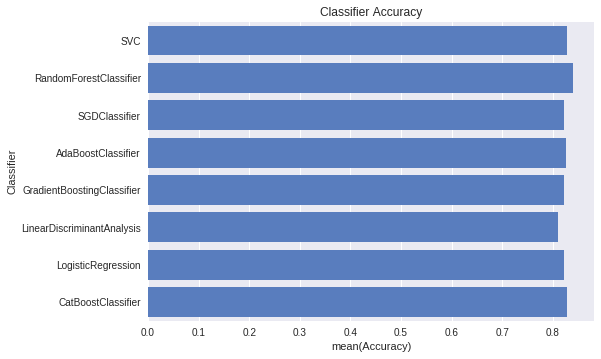

In [55]:
  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)

 #{'AdaBoostClassifier': 0.7950617283950618,
 #'CatBoostClassifier': 0.8185185185185185,
 #'DecisionTreeClassifier': 0.774074074074074,
 #'GaussianNB': 0.7358024691358025,
 #'GradientBoostingClassifier': 0.8160493827160493,
 #'KNeighborsClassifier': 0.7777777777777777,
 #'LinearDiscriminantAnalysis': 0.8135802469135802,
 #'LogisticRegression': 0.8209876543209876,
 #'RandomForestClassifier': 0.8246913580246913,
 #'SGDClassifier': 0.8185185185185185,
 #'SVC': 0.8160493827160493}


classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False),
    #DecisionTreeClassifier(),
    RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200),
    SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True),
    AdaBoostClassifier(RandomForestClassifier(max_depth=10,  criterion='gini', min_samples_leaf=1, min_samples_split=2), n_estimators=36, learning_rate=0.802656626129159, algorithm="SAMME"),
    GradientBoostingClassifier(),
    #GaussianNB(),
    LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='newton-cg'),
    CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = X_mod
y = y_mod

acc_dict = {}

for train_index, test_index in sss.split(X_mod, y_mod):
	X_train, X_test = X.iloc[train_index], X.iloc[test_index]
	y_train, y_test = y.iloc[train_index], y.iloc[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [56]:
 acc_dict
  

{'AdaBoostClassifier': 0.8255555555555555,
 'CatBoostClassifier': 0.8277777777777778,
 'GradientBoostingClassifier': 0.821111111111111,
 'LinearDiscriminantAnalysis': 0.8099999999999999,
 'LogisticRegression': 0.821111111111111,
 'RandomForestClassifier': 0.8399999999999999,
 'SGDClassifier': 0.8222222222222222,
 'SVC': 0.8277777777777777}

In [57]:
classifiers

[SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.5565289675398223,
   kernel='rbf', max_iter=-1, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.8, learning_rate='optimal',
        loss='log', max_iter=1000, n_iter=None, n_jobs=1,
        penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
        tol=None, verbose=0, wa

In [58]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X_train0)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y_train0, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8801498127340824


In [59]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X_test0)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y_test0, rounded)
print("Predictions of X_test", acc)

Predictions of X_test 0.9


In [0]:
import pandas as pd

test = pd.read_csv("./data/test.csv")

hold = holdout_mod.drop(["PassengerId"],axis=1)

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(hold)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_Ensemble_Voting2.csv",index=False)

**Score of 0.78947**

# 14 - VotingClassifier from Sklearn: Bad Score of 0.77990

In [61]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    ('svm', SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)),
    #(DecisionTreeClassifier(),
    ('rf', RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)),
    ('sg',SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True)),
 	  #AdaBoostClassifier(RandomForestClassifier(max_depth=15), n_estimators=200, learning_rate=0.1, algorithm="SAMME"),
    ('gb',GradientBoostingClassifier()),
    #GaussianNB()),
    ('ld', LinearDiscriminantAnalysis()),
    #QuadraticDiscriminantAnalysis()),
    ('logr', LogisticRegression(solver='newton-cg')),
    ('catb', CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'))]


eclf1 = VotingClassifier(classifiers, voting='soft', flatten_transform=True)


eclf1 = eclf1.fit(X_mod, y_mod)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0:	learn: 0.6265622	total: 176ms	remaining: 3.34s
1:	learn: 0.5910866	total: 203ms	remaining: 1.83s
2:	learn: 0.5649577	total: 224ms	remaining: 1.27s
3:	learn: 0.5313262	total: 244ms	remaining: 977ms
4:	learn: 0.4995271	total: 275ms	remaining: 824ms
5:	learn: 0.4776072	total: 306ms	remaining: 714ms
6:	learn: 0.4566935	total: 392ms	remaining: 727ms
7:	learn: 0.4460178	total: 417ms	remaining: 626ms
8:	learn: 0.4351366	total: 442ms	remaining: 541ms
9:	learn: 0.4232154	total: 549ms	remaining: 549ms
10:	learn: 0.4179599	total: 567ms	remaining: 464ms
11:	learn: 0.4128288	total: 589ms	remaining: 392ms
12:	learn: 0.4043546	total: 695ms	remaining: 374ms
13:	learn: 0.3969661	total: 774ms	remaining: 332ms
14:	learn: 0.3918912	total: 819ms	remaining: 273ms
15:	learn: 0.3861208	total: 926ms	remaining: 231ms
16:	learn: 0.3845066	total: 949ms	remaining: 167ms
17:	learn: 0.3799393	total: 976ms	remaining: 108ms
18:	learn: 0.3792572	total: 994ms	remaining: 52.3ms
19:	learn: 0.3762985	total: 1.04s	remain

In [62]:
eclf1

VotingClassifier(estimators=[('svm', SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5565289675398223,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)), ('rf', RandomForestClassifie...erbose=0, warm_start=False)), ('catb', <catboost.core.CatBoostClassifier object at 0x7f2f9272ebe0>)],
         flatten_transform=True, n_jobs=1, voting='soft', weights=None)

In [63]:
print(eclf1.score(X_mod, y_mod))

0.8799102132435466


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [64]:
hold = holdout_mod.drop(["PassengerId"],axis=1)

predictions = eclf1.predict(hold)
 
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_VotingClassifier0.csv",index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


![alt text](https://drive.google.com/uc?export=view&id=1CpmCiebxXoQ-_B1eqNa9-GhYG2hqhUoe)


# 15 - New Pre-processing with VotingClassifier from Sklearn: Bad Score of 0.77990

In [65]:
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('./data/train.csv', header=0, dtype={'Age': np.float64})
test = pd.read_csv('./data/test.csv', header=0, dtype={'Age': np.float64})
full_data = [train, test]

### PRE-PROCESSING

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', \
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 10, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 20), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 20) & (dataset['Fare'] <= 30), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 30, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

train['CategoricalFare'] = pd.cut(train['Fare'], 4)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)
#train = train.values
#test = test.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    ('svm', SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)),
    #(DecisionTreeClassifier(),
    ('rf', RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)),
    ('sg',SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True)),
 	  #AdaBoostClassifier(RandomForestClassifier(max_depth=15), n_estimators=200, learning_rate=0.1, algorithm="SAMME"),
    ('gb',GradientBoostingClassifier()),
    #GaussianNB()),
    ('ld', LinearDiscriminantAnalysis()),
    #QuadraticDiscriminantAnalysis()),
    ('logr', LogisticRegression(solver='newton-cg')),
    ('catb', CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'))]


eclf1 = VotingClassifier(classifiers, voting='soft', flatten_transform=True)


from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(X_mod, y_mod, test_size=0.1, random_state=42)

eclf1 = eclf1.fit(train.drop(["Survived"], axis=1), train["Survived"])

0:	learn: 0.6232414	total: 52.3ms	remaining: 994ms
1:	learn: 0.5697006	total: 83.7ms	remaining: 754ms
2:	learn: 0.5381254	total: 105ms	remaining: 597ms
3:	learn: 0.5221776	total: 122ms	remaining: 486ms
4:	learn: 0.5025538	total: 141ms	remaining: 422ms
5:	learn: 0.4864749	total: 159ms	remaining: 370ms
6:	learn: 0.4686170	total: 178ms	remaining: 331ms
7:	learn: 0.4609884	total: 196ms	remaining: 295ms
8:	learn: 0.4507194	total: 226ms	remaining: 276ms
9:	learn: 0.4458649	total: 244ms	remaining: 244ms
10:	learn: 0.4351127	total: 265ms	remaining: 217ms
11:	learn: 0.4323683	total: 283ms	remaining: 188ms
12:	learn: 0.4276415	total: 304ms	remaining: 164ms
13:	learn: 0.4262700	total: 320ms	remaining: 137ms
14:	learn: 0.4174835	total: 340ms	remaining: 113ms
15:	learn: 0.4149255	total: 359ms	remaining: 89.6ms
16:	learn: 0.4102667	total: 381ms	remaining: 67.2ms
17:	learn: 0.4015623	total: 431ms	remaining: 47.9ms
18:	learn: 0.4009957	total: 449ms	remaining: 23.6ms
19:	learn: 0.3998559	total: 472ms	r

In [67]:
print(eclf1.score(train.drop(["Survived"], axis=1), train["Survived"]))

0.856341189674523


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6313683	total: 28.6ms	remaining: 544ms
1:	learn: 0.5876303	total: 56.2ms	remaining: 506ms
2:	learn: 0.5604465	total: 82.2ms	remaining: 466ms
3:	learn: 0.5291858	total: 109ms	remaining: 438ms
4:	learn: 0.5100743	total: 137ms	remaining: 411ms
5:	learn: 0.4908572	total: 164ms	remaining: 383ms
6:	learn: 0.4676569	total: 199ms	remaining: 370ms
7:	learn: 0.4511129	total: 232ms	remaining: 347ms
8:	learn: 0.4465564	total: 255ms	remaining: 311ms
9:	learn: 0.4304886	total: 284ms	remaining: 284ms
10:	learn: 0.4233543	total: 305ms	remaining: 250ms
11:	learn: 0.4192071	total: 325ms	remaining: 217ms
12:	learn: 0.4122704	total: 348ms	remaining: 187ms
13:	learn: 0.4109297	total: 367ms	remaining: 157ms
14:	learn: 0.4098518	total: 387ms	remaining: 129ms
15:	learn: 0.4064988	total: 409ms	remaining: 102ms
16:	learn: 0.4042396	total: 445ms	remaining: 78.5ms
17:	learn: 0.3972059	total: 474ms	remaining: 52.7ms
18:	learn: 0.3964334	total: 496ms	remaining: 26.1ms
19:	learn: 0.3942183	total: 518ms	r

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


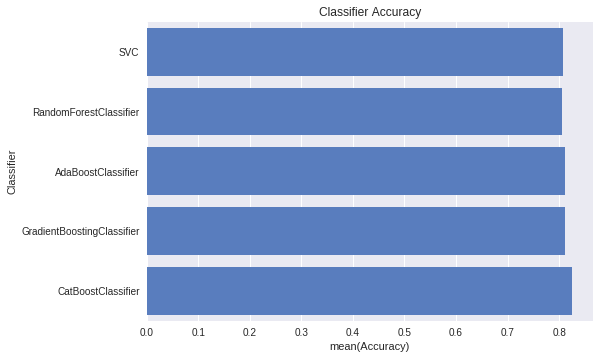

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(train.drop(["Survived"], axis=1), train["Survived"], test_size=0.1, random_state=42)

#{'CatBoostClassifier': 0.8233333333333335,
# 'GradientBoostingClassifier': 0.8188888888888888,
# 'LinearDiscriminantAnalysis': 0.7933333333333332,
# 'LogisticRegression': 0.7944444444444443,
# 'RandomForestClassifier': 0.8088888888888889,
# 'SGDClassifier': 0.7944444444444444,
# 'SVC': 0.8122222222222222}

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False),
    #DecisionTreeClassifier(),
    RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200),
    #SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True),
 	  AdaBoostClassifier(RandomForestClassifier(max_depth=10), n_estimators=48, learning_rate=1.0888, algorithm="SAMME.R"),
    GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    #LogisticRegression(solver='newton-cg'),
    CatBoostClassifier(iterations=20, depth=10, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train.drop(["Survived"], axis=1)
y = train["Survived"]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X.iloc[train_index], X.iloc[test_index]
	y_train, y_test = y.iloc[train_index], y.iloc[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [69]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.867564534231201


In [70]:
acc_dict

{'AdaBoostClassifier': 0.8122222222222222,
 'CatBoostClassifier': 0.8244444444444445,
 'GradientBoostingClassifier': 0.8111111111111111,
 'RandomForestClassifier': 0.8055555555555556,
 'SVC': 0.8077777777777777}

In [0]:
import pandas as pd


hold = test

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(hold)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids, "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_Ensemble_Voting0_section15.csv",index=False)

![alt text](https://drive.google.com/uc?export=view&id=1jUT65euStJbzpF7eKdTHUzRcI_OyphxU)


# 16 -  Another Preprocessing Try-all with KNN: Best Score of 0.83253


Based on  https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83 


In [0]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

Loading datasets


In [0]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
data_df = train_df.append(test_df) # The entire data: train + test.

Engineering features


In [74]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)


data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]


data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])


for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]


data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)


data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)


train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)


X = train_df.drop('Survived', 1)
y = train_df['Survived']
holdout = test_df.copy()



std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
holdout = std_scaler.transform(holdout)



Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


## 16.1 - Best Result of KNN: Score of 0.83253

In [75]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0.879492358564122
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   33.3s finished


In [0]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(holdout)

In [77]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')
knn.fit(X, y)


KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [0]:
y_pred = knn.predict(holdout)

temp = pd.DataFrame(pd.read_csv("./data/test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("./predictions/submission.csv", index = False)

### 16.1.1  - Submition on Kaggle with Best Result of KNN: Score of 0.83253

![alt text](https://drive.google.com/uc?export=view&id=1RZhyZPZAXsXh7Wx0sX-MTfmtIFr2KFv6)

## 16.2 - Another Preprocessing with VotingEnsemble

In [79]:
!pip install catboost


0:	learn: 0.6186050	total: 27.8ms	remaining: 1.25s
1:	learn: 0.5640954	total: 62.2ms	remaining: 1.37s
2:	learn: 0.5258519	total: 86.6ms	remaining: 1.24s
3:	learn: 0.4986069	total: 109ms	remaining: 1.15s
4:	learn: 0.4867832	total: 130ms	remaining: 1.06s
5:	learn: 0.4657114	total: 158ms	remaining: 1.05s
6:	learn: 0.4528657	total: 179ms	remaining: 999ms
7:	learn: 0.4408081	total: 201ms	remaining: 954ms
8:	learn: 0.4364631	total: 222ms	remaining: 911ms
9:	learn: 0.4221056	total: 253ms	remaining: 910ms
10:	learn: 0.4112378	total: 279ms	remaining: 889ms
11:	learn: 0.4014254	total: 311ms	remaining: 882ms
12:	learn: 0.3947767	total: 335ms	remaining: 850ms
13:	learn: 0.3915908	total: 364ms	remaining: 832ms
14:	learn: 0.3870973	total: 395ms	remaining: 816ms
15:	learn: 0.3830173	total: 425ms	remaining: 798ms
16:	learn: 0.3759391	total: 452ms	remaining: 771ms
17:	learn: 0.3755881	total: 476ms	remaining: 740ms
18:	learn: 0.3687789	total: 507ms	remaining: 721ms
19:	learn: 0.3677725	total: 534ms	rema

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


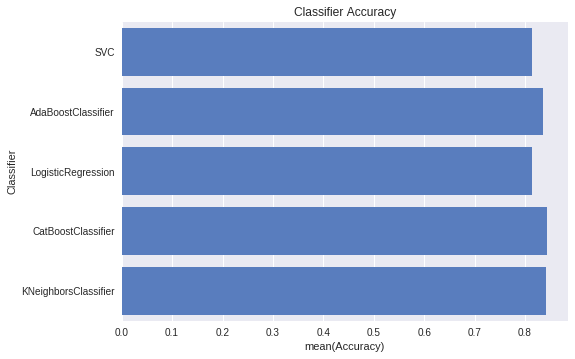

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(train.drop(["Survived"], axis=1), train["Survived"], test_size=0.1, random_state=42)

#{'CatBoostClassifier': 0.8233333333333335,
# 'GradientBoostingClassifier': 0.8188888888888888,
# 'LinearDiscriminantAnalysis': 0.7933333333333332,
#'AdaBoostClassifier': 0.8377777777777776,
# 'CatBoostClassifier': 0.8422222222222222,
# 'GaussianNB': 0.7777777777777777,
# 'KNeighborsClassifier': 0.8422222222222221,
# 'SVC': 0.8133333333333332}
# 'LogisticRegression': 0.7944444444444443,
# 'RandomForestClassifier': 0.8088888888888889,
# 'SGDClassifier': 0.7944444444444444,
# 'SVC': 0.8122222222222222}

classifiers = [
    #KNeighborsClassifier(algorithm='brute', n_neighbors= 3, p= 1, weights='uniform'),
    #SVC(probability=True, C= 1, gamma = 0.1, kernel= 'rbf'),
    SVC(C=9.062264858625882, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.5565289675398223, kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False),
    #DecisionTreeClassifier(),
    #RandomForestClassifier(criterion= 'gini', max_depth=10, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200),
    #SGDClassifier(alpha= 0.001, l1_ratio= 0.8, learning_rate='optimal', loss='log', max_iter= 1000, penalty= 'elasticnet', shuffle= True),
 	  AdaBoostClassifier(RandomForestClassifier(max_depth=6), n_estimators=48, learning_rate=1.0888, algorithm="SAMME.R"),
    #GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='newton-cg'),
    CatBoostClassifier(iterations=46, depth=6, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'),
    KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

#X = train.drop(["Survived"], axis=1)
#y = train["Survived"]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [81]:
acc_dict

{'AdaBoostClassifier': 0.8366666666666666,
 'CatBoostClassifier': 0.8433333333333334,
 'KNeighborsClassifier': 0.8422222222222221,
 'LogisticRegression': 0.8144444444444444,
 'SVC': 0.8133333333333332}

In [82]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8720538720538721


In [0]:
import pandas as pd

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(test_df)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
temp = pd.read_csv("./data/test.csv")

submission_df = {"PassengerId": temp['PassengerId'], "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_Ensemble_Voting1_section16.csv",index=False)

**Score of 0.76076**

## 16.2 - With XGBoost: Score of 0.80861


Based on https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [84]:
!pip install xgboost

In [0]:
import numpy as np

from scipy.stats import uniform, randint


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [0]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [0]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [88]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

print(confusion_matrix(y, y_pred))

[[512  37]
 [ 84 258]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [90]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):   
    X_train0, X_test0= X[train_index], X[test_index]
    y_train0, y_test0 = y[train_index], y[test_index]

    xgb_model = xgb.XGBClassifier(objective="binary:logistic")
    xgb_model.fit(X_train0, y_train0)
    
    y_pred0 = xgb_model.predict(X_test0)
    
    scores.append(accuracy_score(y_test0, y_pred0))
    
display_scores(np.sqrt(scores))

Scores: [0.92452615 0.89943803 0.9451235  0.90255567 0.92408473]
Mean: 0.919
Std: 0.017


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi


**Early stopping**

In [94]:

# if more than one evaluation metric are given the last one is used for early stopping
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train0, y_train0, early_stopping_rounds=5, eval_set=[(X_test0, y_test0)])

y_pred0 = xgb_model.predict(X_test0)

accuracy_score(y_test0, y_pred0)

[0]	validation_0-auc:0.90244
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.90244
[2]	validation_0-auc:0.90244
[3]	validation_0-auc:0.90244
[4]	validation_0-auc:0.90244
[5]	validation_0-auc:0.90244
Stopping. Best iteration:
[0]	validation_0-auc:0.90244



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8609865470852018

In [95]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

best score: 0.90244, best iteration: 0, best ntree limit 1


**Hyperparameter Searching**

In [96]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Model with rank: 1
Mean validation score: 0.848 (std: 0.008)
Parameters: {'colsample_bytree': 0.9519366578369711, 'gamma': 0.43349688000576175, 'learning_rate': 0.15239534860945342, 'max_depth': 2, 'n_estimators': 102, 'subsample': 0.6924299186352285}



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [97]:
search

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=200, n_jobs=1,
          param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f85a900f0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f85a81a90>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f85a815f8>, 'max_depth': <sci...x7f2f85a818d0>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f85a81358>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
       

In [98]:
search.score(X_test0, y_test0)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8878923766816144

In [99]:
y_pred = search.predict(holdout)

temp = pd.DataFrame(pd.read_csv("./data/test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("./predictions/submission_XGBoost_RandomSearch0.csv", index = False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**Score of 0.80861**

### 16.2.1  - Submition on Kaggle with Best Result of XGBoost: Score of 0.80861



![alt text](https://drive.google.com/uc?export=view&id=1KHk2xDOt8BvN8EHXu1nu6-sWop1ZvqSs)



## 16.3  - Best Results: KNN, CATBoost and XGBoost

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6186050	total: 34.1ms	remaining: 1.54s
1:	learn: 0.5640954	total: 69.5ms	remaining: 1.53s
2:	learn: 0.5258519	total: 92ms	remaining: 1.32s
3:	learn: 0.4986069	total: 115ms	remaining: 1.21s
4:	learn: 0.4867832	total: 135ms	remaining: 1.11s
5:	learn: 0.4657114	total: 157ms	remaining: 1.05s
6:	learn: 0.4528657	total: 184ms	remaining: 1.02s
7:	learn: 0.4408081	total: 206ms	remaining: 976ms
8:	learn: 0.4364631	total: 225ms	remaining: 926ms
9:	learn: 0.4221056	total: 256ms	remaining: 920ms
10:	learn: 0.4112378	total: 288ms	remaining: 915ms
11:	learn: 0.4014254	total: 319ms	remaining: 903ms
12:	learn: 0.3947767	total: 347ms	remaining: 880ms
13:	learn: 0.3915908	total: 369ms	remaining: 843ms
14:	learn: 0.3870973	total: 393ms	remaining: 812ms
15:	learn: 0.3830173	total: 416ms	remaining: 781ms
16:	learn: 0.3759391	total: 442ms	remaining: 753ms
17:	learn: 0.3755881	total: 471ms	remaining: 733ms
18:	learn: 0.3687789	total: 503ms	remaining: 715ms
19:	learn: 0.3677725	total: 525ms	remain

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5:	learn: 0.4675838	total: 143ms	remaining: 953ms
6:	learn: 0.4521674	total: 164ms	remaining: 912ms
7:	learn: 0.4373082	total: 185ms	remaining: 880ms
8:	learn: 0.4238286	total: 216ms	remaining: 889ms
9:	learn: 0.4181220	total: 238ms	remaining: 856ms
10:	learn: 0.4147331	total: 270ms	remaining: 859ms
11:	learn: 0.4015879	total: 300ms	remaining: 849ms
12:	learn: 0.3962342	total: 321ms	remaining: 814ms
13:	learn: 0.3877144	total: 352ms	remaining: 805ms
14:	learn: 0.3850860	total: 379ms	remaining: 784ms
15:	learn: 0.3820149	total: 401ms	remaining: 751ms
16:	learn: 0.3803827	total: 426ms	remaining: 727ms
17:	learn: 0.3744080	total: 453ms	remaining: 705ms
18:	learn: 0.3738763	total: 473ms	remaining: 673ms
19:	learn: 0.3720733	total: 495ms	remaining: 643ms
20:	learn: 0.3705734	total: 515ms	remaining: 613ms
21:	learn: 0.3676653	total: 538ms	remaining: 586ms
22:	learn: 0.3660568	total: 570ms	remaining: 570ms
23:	learn: 0.3641992	total: 591ms	remaining: 542ms
24:	learn: 0.3596047	total: 614ms	re

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6367561	total: 28.3ms	remaining: 1.27s
1:	learn: 0.5836129	total: 50.5ms	remaining: 1.11s
2:	learn: 0.5450775	total: 74ms	remaining: 1.06s
3:	learn: 0.5113582	total: 95.9ms	remaining: 1.01s
4:	learn: 0.4915942	total: 125ms	remaining: 1.02s
5:	learn: 0.4672894	total: 154ms	remaining: 1.03s
6:	learn: 0.4532048	total: 180ms	remaining: 1s
7:	learn: 0.4314320	total: 212ms	remaining: 1.01s
8:	learn: 0.4179259	total: 241ms	remaining: 989ms
9:	learn: 0.4134612	total: 269ms	remaining: 968ms
10:	learn: 0.4031443	total: 298ms	remaining: 948ms
11:	learn: 0.4008164	total: 323ms	remaining: 915ms
12:	learn: 0.3918683	total: 354ms	remaining: 900ms
13:	learn: 0.3857823	total: 381ms	remaining: 870ms
14:	learn: 0.3834671	total: 407ms	remaining: 841ms
15:	learn: 0.3816471	total: 433ms	remaining: 812ms
16:	learn: 0.3801559	total: 467ms	remaining: 796ms
17:	learn: 0.3794609	total: 487ms	remaining: 758ms
18:	learn: 0.3762025	total: 515ms	remaining: 732ms
19:	learn: 0.3742112	total: 542ms	remainin

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6146934	total: 27.8ms	remaining: 1.25s
1:	learn: 0.5587683	total: 51.5ms	remaining: 1.13s
2:	learn: 0.5188622	total: 73.1ms	remaining: 1.05s
3:	learn: 0.5030403	total: 92.9ms	remaining: 975ms
4:	learn: 0.4780029	total: 113ms	remaining: 929ms
5:	learn: 0.4530725	total: 136ms	remaining: 909ms
6:	learn: 0.4398858	total: 159ms	remaining: 884ms
7:	learn: 0.4212958	total: 185ms	remaining: 881ms
8:	learn: 0.4162376	total: 212ms	remaining: 870ms
9:	learn: 0.4057863	total: 239ms	remaining: 859ms
10:	learn: 0.3963137	total: 263ms	remaining: 838ms
11:	learn: 0.3855802	total: 289ms	remaining: 818ms
12:	learn: 0.3820294	total: 315ms	remaining: 800ms
13:	learn: 0.3790758	total: 336ms	remaining: 768ms
14:	learn: 0.3781403	total: 356ms	remaining: 735ms
15:	learn: 0.3736090	total: 379ms	remaining: 710ms
16:	learn: 0.3721650	total: 400ms	remaining: 682ms
17:	learn: 0.3702927	total: 423ms	remaining: 657ms
18:	learn: 0.3683579	total: 449ms	remaining: 638ms
19:	learn: 0.3670152	total: 471ms	rem

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6198463	total: 25.1ms	remaining: 1.13s
1:	learn: 0.5686492	total: 46.5ms	remaining: 1.02s
2:	learn: 0.5325102	total: 67.3ms	remaining: 964ms
3:	learn: 0.5055878	total: 93.9ms	remaining: 986ms
4:	learn: 0.4762214	total: 119ms	remaining: 972ms
5:	learn: 0.4584722	total: 139ms	remaining: 929ms
6:	learn: 0.4432653	total: 161ms	remaining: 897ms
7:	learn: 0.4307935	total: 182ms	remaining: 862ms
8:	learn: 0.4161237	total: 211ms	remaining: 865ms
9:	learn: 0.4088706	total: 235ms	remaining: 846ms
10:	learn: 0.3991765	total: 260ms	remaining: 826ms
11:	learn: 0.3919750	total: 283ms	remaining: 803ms
12:	learn: 0.3871555	total: 311ms	remaining: 790ms
13:	learn: 0.3842563	total: 333ms	remaining: 760ms
14:	learn: 0.3832899	total: 353ms	remaining: 731ms
15:	learn: 0.3824359	total: 373ms	remaining: 700ms
16:	learn: 0.3800536	total: 395ms	remaining: 674ms
17:	learn: 0.3752685	total: 428ms	remaining: 666ms
18:	learn: 0.3731930	total: 465ms	remaining: 661ms
19:	learn: 0.3714327	total: 487ms	rem

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


3:	learn: 0.5304217	total: 92.5ms	remaining: 971ms
4:	learn: 0.5075829	total: 117ms	remaining: 958ms
5:	learn: 0.4796479	total: 140ms	remaining: 932ms
6:	learn: 0.4589515	total: 171ms	remaining: 951ms
7:	learn: 0.4426289	total: 205ms	remaining: 974ms
8:	learn: 0.4339767	total: 226ms	remaining: 930ms
9:	learn: 0.4281289	total: 252ms	remaining: 908ms
10:	learn: 0.4181935	total: 280ms	remaining: 891ms
11:	learn: 0.4106860	total: 307ms	remaining: 869ms
12:	learn: 0.4021151	total: 338ms	remaining: 858ms
13:	learn: 0.3955178	total: 369ms	remaining: 844ms
14:	learn: 0.3912775	total: 397ms	remaining: 819ms
15:	learn: 0.3870318	total: 418ms	remaining: 784ms
16:	learn: 0.3860664	total: 439ms	remaining: 749ms
17:	learn: 0.3827249	total: 462ms	remaining: 719ms
18:	learn: 0.3762081	total: 493ms	remaining: 701ms
19:	learn: 0.3734656	total: 530ms	remaining: 689ms
20:	learn: 0.3731522	total: 557ms	remaining: 663ms
21:	learn: 0.3674757	total: 583ms	remaining: 636ms
22:	learn: 0.3671832	total: 603ms	rem

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0:	learn: 0.6220231	total: 25.1ms	remaining: 1.13s
1:	learn: 0.5733411	total: 47.2ms	remaining: 1.04s
2:	learn: 0.5447858	total: 69ms	remaining: 989ms
3:	learn: 0.5127903	total: 91.5ms	remaining: 961ms
4:	learn: 0.4858627	total: 115ms	remaining: 941ms
5:	learn: 0.4656266	total: 136ms	remaining: 910ms
6:	learn: 0.4472707	total: 158ms	remaining: 880ms
7:	learn: 0.4369407	total: 179ms	remaining: 849ms
8:	learn: 0.4278668	total: 203ms	remaining: 836ms
9:	learn: 0.4149031	total: 232ms	remaining: 835ms
10:	learn: 0.4068021	total: 254ms	remaining: 809ms
11:	learn: 0.4034101	total: 281ms	remaining: 796ms
12:	learn: 0.4018708	total: 301ms	remaining: 763ms
13:	learn: 0.3970700	total: 326ms	remaining: 745ms
14:	learn: 0.3949165	total: 356ms	remaining: 735ms
15:	learn: 0.3920035	total: 383ms	remaining: 717ms
16:	learn: 0.3899441	total: 408ms	remaining: 697ms
17:	learn: 0.3886030	total: 439ms	remaining: 683ms
18:	learn: 0.3877466	total: 461ms	remaining: 655ms
19:	learn: 0.3830271	total: 491ms	remai

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1:	learn: 0.5692503	total: 53.3ms	remaining: 1.17s
2:	learn: 0.5340732	total: 75.5ms	remaining: 1.08s
3:	learn: 0.5084705	total: 105ms	remaining: 1.1s
4:	learn: 0.4880212	total: 134ms	remaining: 1.1s
5:	learn: 0.4662943	total: 163ms	remaining: 1.08s
6:	learn: 0.4513174	total: 190ms	remaining: 1.06s
7:	learn: 0.4403589	total: 219ms	remaining: 1.04s
8:	learn: 0.4338444	total: 245ms	remaining: 1.01s
9:	learn: 0.4307248	total: 275ms	remaining: 991ms
10:	learn: 0.4175539	total: 309ms	remaining: 982ms
11:	learn: 0.4065790	total: 341ms	remaining: 966ms
12:	learn: 0.4001660	total: 370ms	remaining: 939ms
13:	learn: 0.3974870	total: 396ms	remaining: 905ms
14:	learn: 0.3947791	total: 423ms	remaining: 875ms
15:	learn: 0.3898582	total: 447ms	remaining: 838ms
16:	learn: 0.3852079	total: 482ms	remaining: 823ms
17:	learn: 0.3837356	total: 509ms	remaining: 792ms
18:	learn: 0.3800656	total: 538ms	remaining: 764ms
19:	learn: 0.3785050	total: 564ms	remaining: 733ms
20:	learn: 0.3748572	total: 591ms	remain

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1:	learn: 0.6083478	total: 44.8ms	remaining: 986ms
2:	learn: 0.5597673	total: 71.5ms	remaining: 1.02s
3:	learn: 0.5172906	total: 98.6ms	remaining: 1.03s
4:	learn: 0.4919873	total: 125ms	remaining: 1.02s
5:	learn: 0.4679549	total: 151ms	remaining: 1.01s
6:	learn: 0.4489468	total: 173ms	remaining: 964ms
7:	learn: 0.4324806	total: 201ms	remaining: 955ms
8:	learn: 0.4275717	total: 222ms	remaining: 912ms
9:	learn: 0.4154906	total: 250ms	remaining: 901ms
10:	learn: 0.4065752	total: 272ms	remaining: 864ms
11:	learn: 0.4024955	total: 293ms	remaining: 829ms
12:	learn: 0.3981844	total: 314ms	remaining: 797ms
13:	learn: 0.3931143	total: 346ms	remaining: 792ms
14:	learn: 0.3896523	total: 384ms	remaining: 793ms
15:	learn: 0.3782335	total: 415ms	remaining: 779ms
16:	learn: 0.3730924	total: 438ms	remaining: 748ms
17:	learn: 0.3713444	total: 471ms	remaining: 732ms
18:	learn: 0.3706298	total: 492ms	remaining: 699ms
19:	learn: 0.3700501	total: 513ms	remaining: 666ms
20:	learn: 0.3628451	total: 537ms	rem

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


3:	learn: 0.5110133	total: 93.6ms	remaining: 983ms
4:	learn: 0.4868983	total: 123ms	remaining: 1s
5:	learn: 0.4630496	total: 155ms	remaining: 1.03s
6:	learn: 0.4447503	total: 177ms	remaining: 987ms
7:	learn: 0.4349575	total: 203ms	remaining: 963ms
8:	learn: 0.4282083	total: 224ms	remaining: 921ms
9:	learn: 0.4121485	total: 250ms	remaining: 899ms
10:	learn: 0.4052003	total: 271ms	remaining: 863ms
11:	learn: 0.4013589	total: 306ms	remaining: 867ms
12:	learn: 0.3946451	total: 331ms	remaining: 841ms
13:	learn: 0.3921475	total: 359ms	remaining: 819ms
14:	learn: 0.3888451	total: 382ms	remaining: 789ms
15:	learn: 0.3839785	total: 407ms	remaining: 764ms
16:	learn: 0.3827939	total: 428ms	remaining: 731ms
17:	learn: 0.3794192	total: 457ms	remaining: 711ms
18:	learn: 0.3763381	total: 479ms	remaining: 681ms
19:	learn: 0.3726013	total: 500ms	remaining: 651ms
20:	learn: 0.3681519	total: 528ms	remaining: 629ms
21:	learn: 0.3679521	total: 551ms	remaining: 601ms
22:	learn: 0.3676956	total: 572ms	remain

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


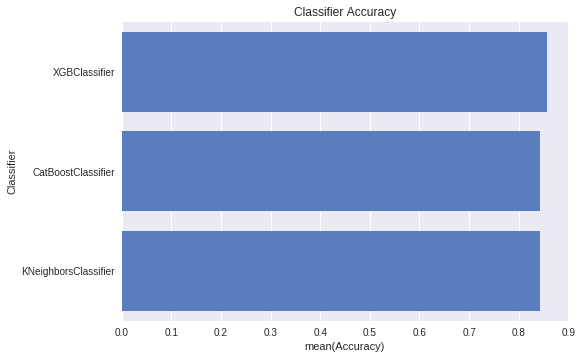

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split

#X_train0, X_test0, y_train0, y_test0 = train_test_split(train.drop(["Survived"], axis=1), train["Survived"], test_size=0.1, random_state=42)


classifiers = [
    xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
    CatBoostClassifier(iterations=46, depth=6, learning_rate=0.1, loss_function='Logloss', logging_level='Verbose'),
    KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

#X = train.drop(["Survived"], axis=1)
#y = train["Survived"]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [101]:
acc_dict

{'CatBoostClassifier': 0.8433333333333334,
 'KNeighborsClassifier': 0.8422222222222221,
 'XGBClassifier': 0.8566666666666667}

In [102]:
predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(X)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined)
 
acc = accuracy_score(y, rounded)
print("Predictions of X_train", acc)

Predictions of X_train 0.8653198653198653


In [0]:
import pandas as pd

predictions = []

for clf in classifiers:
  predictions.append(clf.predict_proba(holdout)[:,1])
    
combined = np.sum(predictions, axis=0) / len(classifiers)     
rounded = np.round(combined).astype(int)
 
temp = pd.read_csv("./data/test.csv")

submission_df = {"PassengerId": temp['PassengerId'], "Survived": rounded}
submission = pd.DataFrame(submission_df)
submission.to_csv("./predictions/submission_Voting_CatBoost_KNN_XGB.csv",index=False)

### 16.3.1 Submition on Kaggle with Voting: score of 0.79425


![alt text](https://drive.google.com/uc?export=view&id=1FD9RVt-RM-lfAR0ynVfOmcMO9mCzX4rk)

